In [44]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tabulate import tabulate

In [45]:
!nvidia-smi

Tue Sep  1 18:40:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8    18W / 300W |  10504MiB / 11016MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [46]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Download

In [47]:
# !mkdir data
# !wget -q -O data/clean_mex_data.csv https://www.dropbox.com/s/h22cg25jszu2360/clean_mex_data.csv?dl=1

In [48]:
df = pd.read_csv('../data/clean_mex_data.csv')
main_df = df.copy(deep=True)

In [49]:
FEATURES = ['act_x', 'act_y', 'act_z','acw_x', 'acw_y', 'acw_z']
FEATURES_THIGH = ['act_x', 'act_y', 'act_z']
FEATURES_WRIST = ['acw_x', 'acw_y', 'acw_z']
LABELS = 'activity'

In [50]:
def get_activity_dict(novel_classes:list):
    activity_map = {1:'Knee Rolling',2:'Bridging', 3:'Pelvic tilt', 4:'The Clam',5:'Repeated Extension in Lying', 6:'Prone punches',7:'Superman'}
    novel_map = dict()
    for activity_class in novel_classes:
        novel_map[activity_class] = activity_map[activity_class]
        activity_map.pop(activity_class)
        
    return activity_map, novel_map

In [1]:
activity_map = {1:'Knee Rolling',2:'Bridging', 3:'Pelvic tilt', 4:'The Clam',5:'Repeated Extension in Lying', 6:'Prone punches',7:'Superman'}

In [2]:
activity_map

{1: 'Knee Rolling',
 2: 'Bridging',
 3: 'Pelvic tilt',
 4: 'The Clam',
 5: 'Repeated Extension in Lying',
 6: 'Prone punches',
 7: 'Superman'}

In [5]:
import json

with open("activities/mex_activity.json", "w") as outfile:  
    json.dump(activity_map, outfile, indent = 4) 

In [51]:
NOVEL_CLASSES = [3, 6]

In [52]:
activity_map, novel_map = get_activity_dict(NOVEL_CLASSES)

In [53]:
print(activity_map)
print(novel_map)

{1: 'Knee Rolling', 2: 'Bridging', 4: 'The Clam', 5: 'Repeated Extension in Lying', 7: 'Superman'}
{3: 'Pelvic tilt', 6: 'Prone punches'}


### scaling

In [54]:
df[FEATURES] = df[FEATURES]/100
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [55]:
holdout_data = df.loc[df['activity'].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

In [56]:
def add_noise(df:pd.DataFrame, feat_list:list, num_features=6, num_augmented_samples=4, mu=0.0, sigma=0.5):
    df_aug = df.copy(deep=True)

    for _ in range(num_augmented_samples):
        noise = np.random.normal(mu, sigma, [df.shape[0], num_features])

        df_noise = df[['act_x', 'act_y', 'act_z', 'acw_x', 'acw_y', 'acw_z']].copy(deep=True)
        df_noise = df_noise + noise

        df_noise['timestamp'] = df['timestamp']
        df_noise['subject_id'] = df['subject_id']
        df_noise['activity'] = df['activity']

        df_noise = df_noise[df.columns]

        df_aug = pd.concat([df_aug, df_noise], ignore_index=True)

    return df_aug

In [57]:
df.shape

(884385, 9)

In [58]:
novel_data.shape

(345454, 9)

### Train test split

<AxesSubplot:xlabel='subject_id', ylabel='count'>

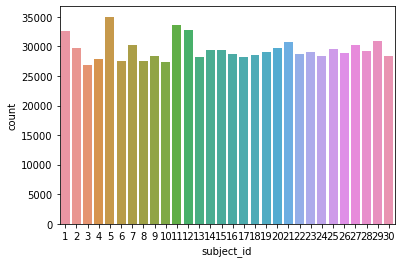

In [59]:
sns.countplot(x='subject_id', data=df)

In [60]:
train_sub = list(range(6,31))
# train_sub.extend(list(range(26,31)))
val_sub = list(range(1,6))
test_sub = list(range(1,6))

In [61]:
train_df = df[df['subject_id'].isin(train_sub)]
val_df =  df[df['subject_id'].isin(val_sub)]
test_df = df[df['subject_id'].isin(test_sub)]

In [62]:
train_df = add_noise(train_df, feat_list=FEATURES)

## windowing

In [63]:
WINDOW_SIZE=2000
STRIDE = 300

In [64]:
def create_windowed_dataset(df, features= FEATURES, class_label = LABELS, window_size=2000, stride = 300):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []

    seg_start= 0
    seg_end = window_size
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels)

In [65]:
X_train, y_train = create_windowed_dataset(train_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
X_val, y_val = create_windowed_dataset(val_df, FEATURES,window_size=WINDOW_SIZE, stride = STRIDE)
X_test, y_test = create_windowed_dataset(test_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

In [66]:
X_holdout, y_holdout = create_windowed_dataset(novel_data, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

In [67]:
N_WINDOW = 10
N_TIMESTEP = 200

In [68]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 6))
X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, 6))

y_train = tf.keras.utils.to_categorical(y_train-1)
y_val = tf.keras.utils.to_categorical(y_val-1)
y_test = tf.keras.utils.to_categorical(y_test-1)
y_holdout = tf.keras.utils.to_categorical(y_holdout-1)

In [69]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

print(X_holdout.shape)
print(y_holdout.shape)

(8375, 10, 200, 6)
(8375, 7)
(354, 10, 200, 6)
(354, 7)
(354, 10, 200, 6)
(354, 7)
(783, 10, 200, 6)
(783, 6)


## Attention Model

In [70]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

### Self Attention

In [71]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [72]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [73]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [74]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [75]:
class CombinedSensorAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CombinedSensorAttention, self).__init__()
        self.agr_attn = AttentionWithContext(return_attention=True)
    
    def call(self, x):
        x = tf.concat(x, axis=1)
        x, attn_score = self.agr_attn(x)
        return x, attn_score

In [76]:
class CombinedSensorSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate, concat=True):
        super(CombinedSensorSelfAttention, self).__init__()
        self.concat = concat
        self.agr_attn = AggregateAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        if self.concat:
            x = tf.concat(x, axis=1)
        x, attn_score = self.agr_attn(x, x)
        x = self.dropout1(x)
        ffn_output = self.ffn(x)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm(ffn_output + x)  # (batch_size, d_model)
        return out, attn_score

In [77]:
class DataTransform(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(DataTransform, self).__init__()
        # self.ln = tf.keras.layers.LayerNormalization()
        self.conv_1d = tf.keras.layers.Conv1D(d_model, 1, activation='relu')
    
    def call(self, x):
        # x = self.ln(x)
        x = self.conv_1d(x)
        return x

In [78]:
class ModalityEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=2, dropout_rate=0.1):
        super(ModalityEncoderBlock, self).__init__()
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.look_ahead_mask = create_look_ahead_mask(n_timesteps)
        self.data_transform = DataTransform(d_model)
        self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.num_sa_blocks = num_sa_blocks
        self.self_attn_blocks = [ SelfAttentionBlock(d_model, num_heads, dff, dropout_rate)
                                        for _ in range(self.num_sa_blocks)]
        # self.agr_attn = AttentionWithContext(return_attention=True)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.data_transform(x)
        x = self.pe(x)
        for i in range(self.num_sa_blocks):
            # x = self.self_attn_blocks[i](x, mask=self.look_ahead_mask)
            x = self.self_attn_blocks[i](x)
        # x, attn_score = self.agr_attn(x)
        # return x, attn_score
        return x


    # def compute_output_shape(x, input_shape):
    #     return tf.TensorShape([input_shape, self.d_model])

In [79]:
def get_modality_encoder(modality_indices, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
    model = tf.keras.Model(inputs=inputs, outputs=modality_outputs)
    return model

In [80]:
class MultiWindowEncoder(tf.keras.layers.Layer):
    def __init__(self, modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1):
        super(MultiWindowEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.window_encoder = get_modality_encoder(modality_indices,n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs, d_model=d_model, num_heads = num_heads, dff=dff, dropout_rate=dropout_rate)
        self.combined_sensor_attn = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_dim = tf.shape(x)[-1]
        x = tf.reshape(x, (-1, self.n_timesteps, feature_dim)) # all sessions in batch dim
        x = self.window_encoder(x)
        x, attn_scores = self.combined_sensor_attn(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model))
        attn_scores = tf.reshape(attn_scores, (batch_size, -1, self.n_timesteps))
        return x, attn_scores

In [81]:
# def get_modality_model(modality_indices, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
#     num_modality = len(modality_indices)-1
#     inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
#     attn_scores = []
#     modality_outputs = []
#     for i in range(num_modality):
#             modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
#             # modality_x, attn_score = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=nh, dff=dff, num_sa_blocks=2)(modality_x)
#             # modality_outputs.append(modality_x)
#             modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
#             modality_outputs.append(modality_x)
#             # attn_score = tf.keras.layers.Flatten() (attn_score)
#             # attn_scores.append(attn_score)
#     x, _ = CombinedSensorAttention() (modality_outputs)
#     predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
#     model = tf.keras.Model(inputs=inputs, outputs=predictions)
#     return model

In [82]:
def get_modality_model_w_time_hierarchy(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=True) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

In [83]:
def get_hierarchical_vae_model(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=False) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

## Training

In [84]:
tf.keras.backend.clear_session()

n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]

# Create a MirroredStrategy.
model = get_modality_model_w_time_hierarchy([0, 3, 6],n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics='accuracy')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 200, 6)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 250048    
_________________________________________________________________
modality_encoder_block_2 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 49856     
_________________________________________________________________
dense_48 (Dense)             (None, 7)                 455       
Total params: 404,359
Trainable params: 404,359
Non-trainable params: 0
_________________________________________________________________


In [42]:
verbose, epochs, batch_size = 1, 50, 128
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,verbose=1, mode='max')
#mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              verbose=verbose, validation_data=(X_val, y_val))

Epoch 1/50
66/66 [==============================] - 20s 306ms/step - loss: 1.3711 - accuracy: 0.4607 - val_loss: 0.6941 - val_accuracy: 0.7401
Epoch 2/50
66/66 [==============================] - 19s 291ms/step - loss: 0.3920 - accuracy: 0.8630 - val_loss: 0.5669 - val_accuracy: 0.9153
Epoch 3/50
66/66 [==============================] - 19s 291ms/step - loss: 0.1802 - accuracy: 0.9413 - val_loss: 0.6210 - val_accuracy: 0.9040
Epoch 4/50
66/66 [==============================] - 19s 290ms/step - loss: 0.1111 - accuracy: 0.9653 - val_loss: 0.6407 - val_accuracy: 0.8390
Epoch 5/50
66/66 [==============================] - 19s 292ms/step - loss: 0.0743 - accuracy: 0.9767 - val_loss: 0.8147 - val_accuracy: 0.8164
Epoch 6/50
66/66 [==============================] - 19s 290ms/step - loss: 0.0607 - accuracy: 0.9827 - val_loss: 0.8043 - val_accuracy: 0.8503
Epoch 7/50
66/66 [==============================] - 19s 290ms/step - loss: 0.0464 - accuracy: 0.9860 - val_loss: 1.0501 - val_accuracy: 0.7938

In [43]:
pred = model.predict(X_test, batch_size=128)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=list(activity_map.values())))

                             precision    recall  f1-score   support

               Knee Rolling       1.00      0.50      0.67        60
                   Bridging       0.69      0.85      0.76        80
                   The Clam       0.75      1.00      0.85        76
Repeated Extension in Lying       0.66      0.63      0.64        70
                   Superman       1.00      0.84      0.91        68

                   accuracy                           0.78       354
                  macro avg       0.82      0.76      0.77       354
               weighted avg       0.81      0.78      0.77       354



<AxesSubplot:>

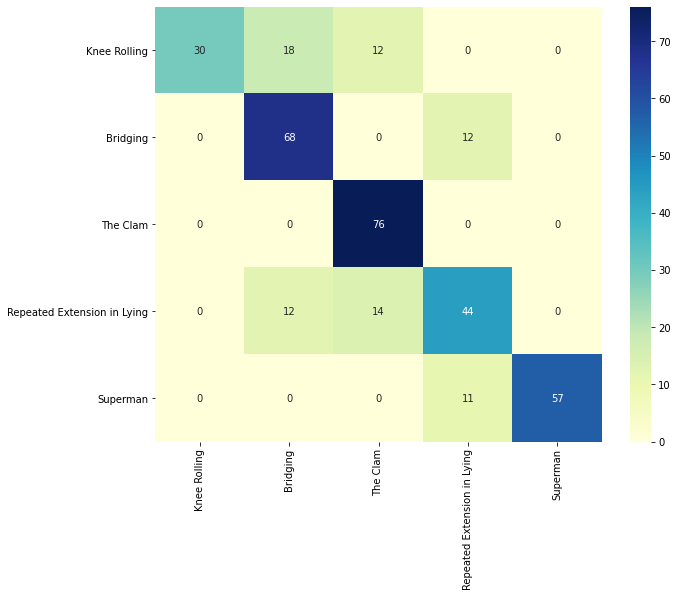

In [46]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [47]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_2
combined_sensor_self_attention_1
dense_48


In [48]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [49]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 200, 6)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 250048    
_________________________________________________________________
modality_encoder_block_2 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 49856     
Total params: 403,904
Trainable params: 0
Non-trainable params: 403,904
_________________________________________________________________


## VAE [Novelty Detection]

In [50]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data, _ = self.base_model(data)
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, reconstructed))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [51]:
hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

In [53]:
vae_history = hsa_vae.fit(X_train, epochs=35, batch_size=128)

Epoch 1/35
66/66 [==============================] - 8s 116ms/step - loss: 1.3956 - reconstruction_loss: 1.2315 - kl_loss: 0.1641
Epoch 2/35
66/66 [==============================] - 8s 117ms/step - loss: 1.1311 - reconstruction_loss: 1.1099 - kl_loss: 0.0212
Epoch 3/35
66/66 [==============================] - 8s 117ms/step - loss: 1.0681 - reconstruction_loss: 1.0535 - kl_loss: 0.0146
Epoch 4/35
66/66 [==============================] - 8s 117ms/step - loss: 1.0427 - reconstruction_loss: 1.0277 - kl_loss: 0.0151
Epoch 5/35
66/66 [==============================] - 8s 117ms/step - loss: 1.0221 - reconstruction_loss: 0.9981 - kl_loss: 0.0241
Epoch 6/35
66/66 [==============================] - 8s 117ms/step - loss: 1.0013 - reconstruction_loss: 0.9599 - kl_loss: 0.0414
Epoch 7/35
66/66 [==============================] - 8s 116ms/step - loss: 0.9793 - reconstruction_loss: 0.9215 - kl_loss: 0.0578
Epoch 8/35
66/66 [==============================] - 8s 117ms/step - loss: 0.9598 - reconstruction

In [54]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [93]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [94]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [95]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [96]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [101]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [114]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.5)

              precision    recall  f1-score   support

       KNOWN       0.32      0.36      0.34       354
       NOVEL       0.69      0.65      0.67       783

    accuracy                           0.56      1137
   macro avg       0.51      0.51      0.51      1137
weighted avg       0.58      0.56      0.57      1137



### Novelty Detection Result

In [86]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [164]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [223]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.01, 0.51, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

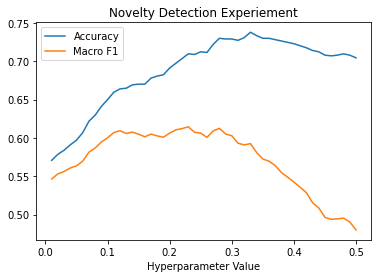

Index with Top Accuracy and Macro F1 :  [32 33 31 27 34] [22 27 21 20 11]
Most Important Index :  [27]
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0.01 |   0.5708   |   0.546538 |
+---------+-------------------------+------------+------------+
|       1 |                    0.02 |   0.578716 |   0.553143 |
+---------+-------------------------+------------+------------+
|       2 |                    0.03 |   0.583993 |   0.556311 |
+---------+-------------------------+------------+------------+
|       3 |                    0.04 |   0.591029 |   0.560863 |
+---------+-------------------------+------------+------------+
|       4 |                    0.05 |   0.597186 |   0.563698 |
+---------+-------------------------+------------+------------+
|       5 |                    0.06 |   0.60686  |   0.569731 |
+

In [226]:
# Result
hparam_search() 

## Leave One Subject Out (LOSO) Experiment

In [101]:
def run_experiment(df, BATCH_SIZE =128, N_WINDOW = 20, N_TIMESTEP = 100):
    
    activity_map = {1:'Knee Rolling',2:'Bridging', 3:'Pelvic tilt', 4:'The Clam',5:'Repeated Extension in Lying', 6:'Prone punches', 7:'Superman'}

    full_sub = set(range(1,31))
    SHUFFLE_BUFFER_SIZE = 2048
    WINDOW_SIZE=2000
    STRIDE=300
    N_WINDOW, N_TIMESTEP = 10, 200
    
    for i in range(1, 30, 5):
        test_sub = set(range(i, i + 5))
        train_sub = full_sub - test_sub
        print('test subjects', test_sub)
        print('train subjects', train_sub)
        
        train_df = df[df['subject_id'].isin(train_sub)]
        test_df = df[df['subject_id'].isin(test_sub)]
        
#         train_df = add_noise(train_df, feat_list=FEATURES)

        X_train, y_train = create_windowed_dataset(train_df, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
        X_test, y_test = create_windowed_dataset(test_df, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 6))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 6))

        y_train = tf.keras.utils.to_categorical(y_train-1)
        y_test = tf.keras.utils.to_categorical(y_test-1)

#         train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#         test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
#         train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#         test_dataset = test_dataset.batch(BATCH_SIZE)

        tf.keras.backend.clear_session()
        n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
        model = get_modality_model_w_time_hierarchy([0,3,6],n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
        
        verbose, epochs, batch_size = 2, 50, 64
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))
        
        pred = model.predict(X_test, batch_size=64)
        
#         print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=list(activity_map.values()), zero_division=1))
        
        out_res = open(os.path.join('result/mex', str('subject_' + str(i).zfill(2) + '_' + str(i + 4).zfill(2) + '.txt')), 'w')
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), labels=np.unique(np.argmax(y_test, axis=1)),
                                    target_names=list(activity_map.values()), zero_division=1), file=out_res)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), 
                                    labels=np.unique(np.argmax(y_test, axis=1)), target_names=list(activity_map.values()), zero_division=1))

        out_res.close()
        
        confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), normalize='true')
        activity_list = np.array(list(activity_map.values()))[np.union1d(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))]
        df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
        plt.figure(figsize = (10,8))
        sns.heatmap(df_cm, annot=True, linewidths=0.05, cmap="YlGnBu")
        
        out_fig = 'subject_' + str(i).zfill(2) + '_ '+ str(i + 4).zfill(2) + '.png'
        plt.savefig(os.path.join('figures/mex', out_fig))

        plt.show()


test subjects {1, 2, 3, 4, 5}
train subjects {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
92/92 [==============================] - 23s 253ms/step - loss: 1.0832 - accuracy: 0.5585 - val_loss: 1.0502 - val_accuracy: 0.6836
Epoch 2/50
92/92 [==============================] - 22s 241ms/step - loss: 0.3739 - accuracy: 0.8427 - val_loss: 1.4874 - val_accuracy: 0.6412
Epoch 3/50
92/92 [==============================] - 22s 242ms/step - loss: 0.2780 - accuracy: 0.8896 - val_loss: 1.4296 - val_accuracy: 0.7542
Epoch 4/50
92/92 [==============================] - 22s 243ms/step - loss: 0.2347 - accuracy: 0.9059 - val_loss: 1.4089 - val_accuracy: 0.7571
Epoch 5/50
92/92 [==============================] - 22s 242ms/step - loss: 0.1657 - accuracy: 0.9403 - val_loss: 1.3468 - val_accuracy: 0.7740
Epoch 6/50
92/92 [==============================] - 22s 243ms/step - loss: 0.1694 - accuracy: 0.9381 - val_loss: 1.2520 - val_accuracy: 0.7966


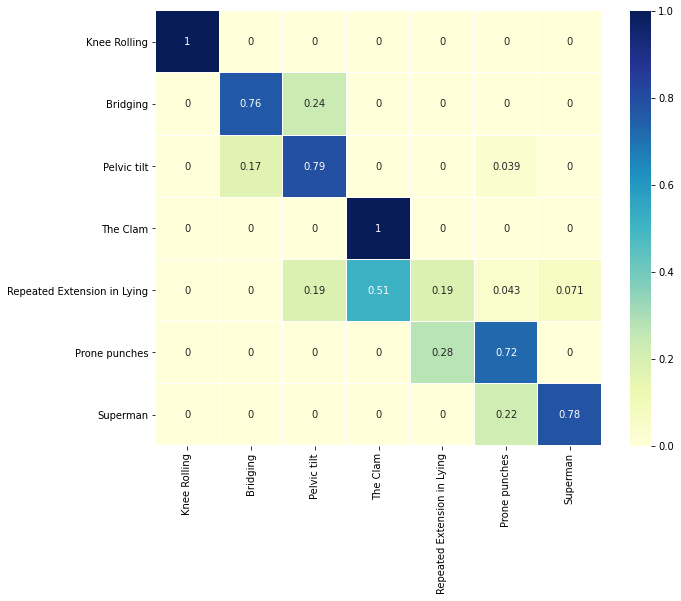

test subjects {6, 7, 8, 9, 10}
train subjects {1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
92/92 [==============================] - 23s 255ms/step - loss: 1.5893 - accuracy: 0.3480 - val_loss: 0.6619 - val_accuracy: 0.8644
Epoch 2/50
92/92 [==============================] - 22s 244ms/step - loss: 0.6138 - accuracy: 0.7317 - val_loss: 0.5014 - val_accuracy: 0.7655
Epoch 3/50
92/92 [==============================] - 22s 244ms/step - loss: 0.3598 - accuracy: 0.8490 - val_loss: 0.5133 - val_accuracy: 0.8249
Epoch 4/50
92/92 [==============================] - 22s 244ms/step - loss: 0.3085 - accuracy: 0.8777 - val_loss: 0.4060 - val_accuracy: 0.8729
Epoch 5/50
92/92 [==============================] - 22s 243ms/step - loss: 0.2740 - accuracy: 0.8966 - val_loss: 0.3545 - val_accuracy: 0.8616
Epoch 6/50
92/92 [==============================] - 22s 244ms/step - loss: 0.4592 - accuracy: 0.8150 - val_loss: 0.5508 - val_accuracy: 0.8362


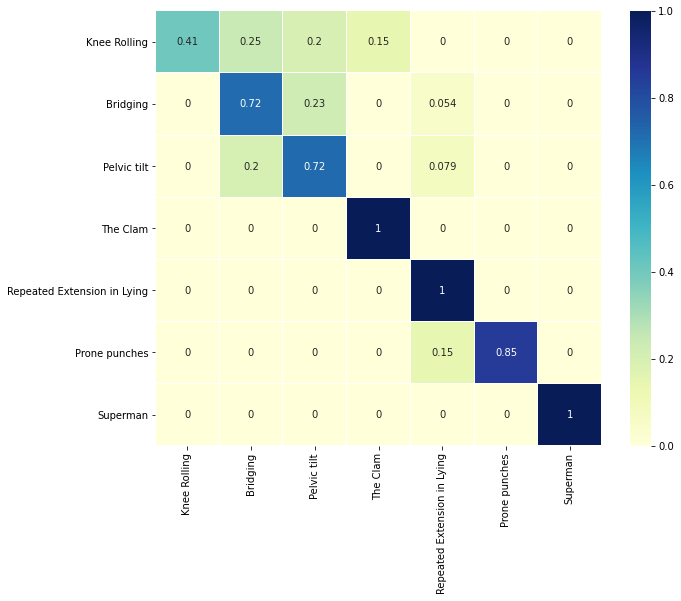

test subjects {11, 12, 13, 14, 15}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
91/91 [==============================] - 23s 255ms/step - loss: 0.9802 - accuracy: 0.5805 - val_loss: 0.4528 - val_accuracy: 0.9237
Epoch 2/50
91/91 [==============================] - 22s 245ms/step - loss: 0.3284 - accuracy: 0.8668 - val_loss: 0.6712 - val_accuracy: 0.8362
Epoch 3/50
91/91 [==============================] - 22s 244ms/step - loss: 0.2255 - accuracy: 0.9133 - val_loss: 0.5509 - val_accuracy: 0.9266
Epoch 4/50
91/91 [==============================] - 22s 245ms/step - loss: 0.2197 - accuracy: 0.9228 - val_loss: 0.2355 - val_accuracy: 0.8729
Epoch 5/50
91/91 [==============================] - 22s 244ms/step - loss: 0.1712 - accuracy: 0.9405 - val_loss: 0.1632 - val_accuracy: 0.9689
Epoch 6/50
91/91 [==============================] - 22s 245ms/step - loss: 0.1571 - accuracy: 0.9415 - val_loss: 0.3526 - val_accuracy: 0.9040


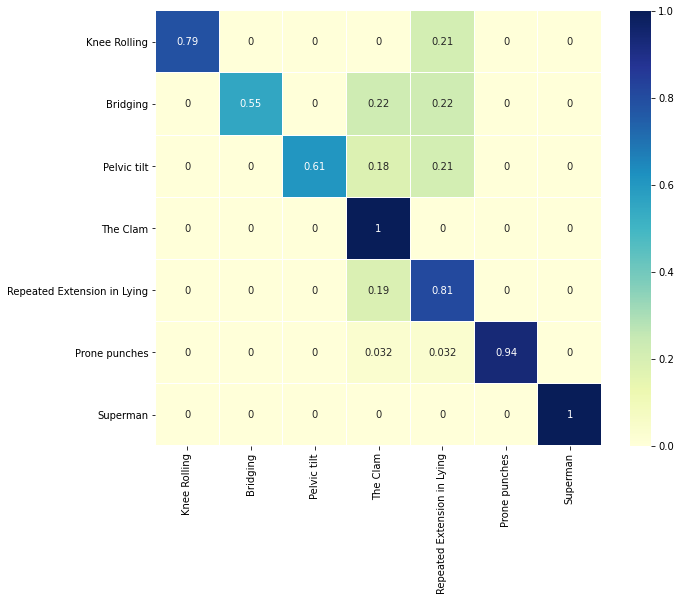

test subjects {16, 17, 18, 19, 20}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
92/92 [==============================] - 23s 254ms/step - loss: 1.9000 - accuracy: 0.1970 - val_loss: 1.3716 - val_accuracy: 0.5311
Epoch 2/50
92/92 [==============================] - 22s 243ms/step - loss: 1.0943 - accuracy: 0.5168 - val_loss: 0.7080 - val_accuracy: 0.6751
Epoch 3/50
92/92 [==============================] - 22s 243ms/step - loss: 0.5912 - accuracy: 0.7486 - val_loss: 0.5069 - val_accuracy: 0.6836
Epoch 4/50
92/92 [==============================] - 22s 243ms/step - loss: 0.6431 - accuracy: 0.7362 - val_loss: 0.5848 - val_accuracy: 0.5424
Epoch 5/50
92/92 [==============================] - 23s 245ms/step - loss: 0.6572 - accuracy: 0.6930 - val_loss: 0.8265 - val_accuracy: 0.7203
Epoch 6/50
92/92 [==============================] - 22s 244ms/step - loss: 0.4684 - accuracy: 0.7769 - val_loss: 0.7087 - val_accuracy: 0.7288


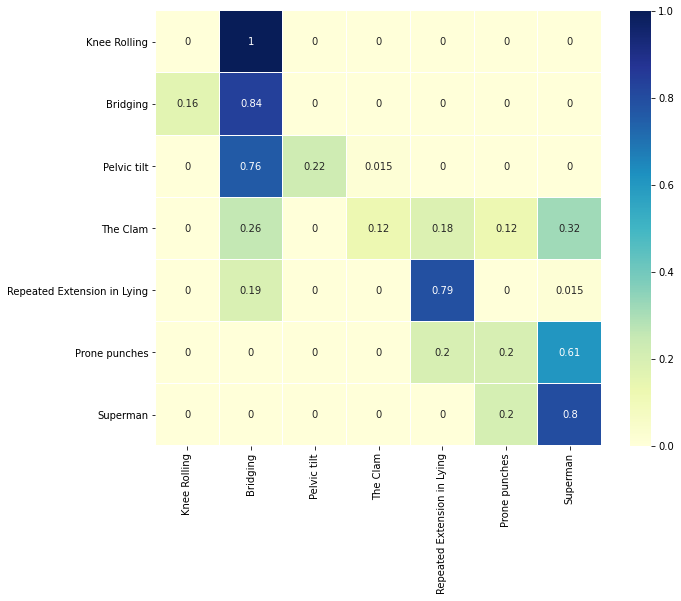

test subjects {21, 22, 23, 24, 25}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30}
Epoch 1/50
92/92 [==============================] - 23s 254ms/step - loss: 1.1364 - accuracy: 0.5271 - val_loss: 0.4267 - val_accuracy: 0.8164
Epoch 2/50
92/92 [==============================] - 23s 245ms/step - loss: 0.3895 - accuracy: 0.8095 - val_loss: 0.4355 - val_accuracy: 0.8136
Epoch 3/50
92/92 [==============================] - 22s 244ms/step - loss: 0.3667 - accuracy: 0.8282 - val_loss: 0.1927 - val_accuracy: 0.8785
Epoch 4/50
92/92 [==============================] - 22s 244ms/step - loss: 0.2590 - accuracy: 0.8768 - val_loss: 0.4606 - val_accuracy: 0.9096
Epoch 5/50
92/92 [==============================] - 23s 245ms/step - loss: 0.2802 - accuracy: 0.8745 - val_loss: 0.2829 - val_accuracy: 0.9040
Epoch 6/50
92/92 [==============================] - 22s 244ms/step - loss: 0.1684 - accuracy: 0.9294 - val_loss: 0.2389 - val_accuracy: 0.9661


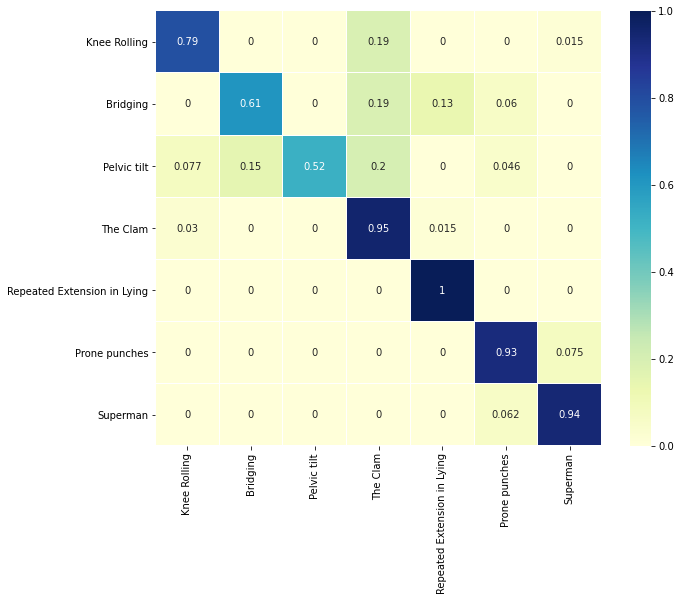

test subjects {26, 27, 28, 29, 30}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Epoch 1/50
92/92 [==============================] - 23s 253ms/step - loss: 1.3645 - accuracy: 0.4584 - val_loss: 0.5914 - val_accuracy: 0.7910
Epoch 2/50
92/92 [==============================] - 22s 242ms/step - loss: 0.4703 - accuracy: 0.8049 - val_loss: 0.4303 - val_accuracy: 0.7768
Epoch 3/50
92/92 [==============================] - 22s 242ms/step - loss: 0.3236 - accuracy: 0.8752 - val_loss: 0.4161 - val_accuracy: 0.8390
Epoch 4/50
92/92 [==============================] - 22s 242ms/step - loss: 0.2869 - accuracy: 0.8915 - val_loss: 0.5173 - val_accuracy: 0.8757
Epoch 5/50
92/92 [==============================] - 22s 244ms/step - loss: 0.2793 - accuracy: 0.8997 - val_loss: 0.2334 - val_accuracy: 0.9096
Epoch 6/50
92/92 [==============================] - 22s 243ms/step - loss: 0.1601 - accuracy: 0.9408 - val_loss: 0.4223 - val_accuracy: 0.9011


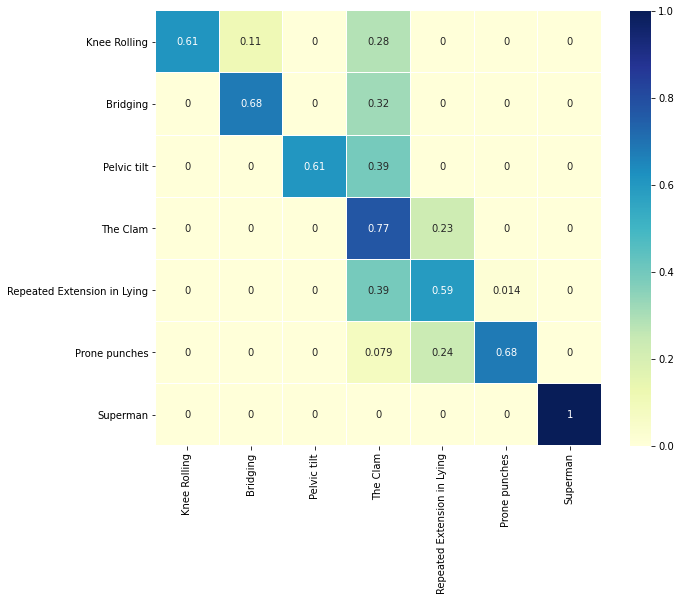

In [86]:
run_experiment(df=main_df)

test subjects {1, 2, 3, 4, 5}
train subjects {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.9226 - accuracy: 0.2401 - val_loss: 1.5200 - val_accuracy: 0.2514
Epoch 2/50
37/37 - 5s - loss: 0.9719 - accuracy: 0.5703 - val_loss: 0.7892 - val_accuracy: 0.8164
Epoch 3/50
37/37 - 5s - loss: 0.5728 - accuracy: 0.7565 - val_loss: 1.1585 - val_accuracy: 0.5678
Epoch 4/50
37/37 - 5s - loss: 0.5154 - accuracy: 0.7894 - val_loss: 1.4792 - val_accuracy: 0.5367
Epoch 5/50
37/37 - 5s - loss: 0.4389 - accuracy: 0.7997 - val_loss: 1.9433 - val_accuracy: 0.6384
Epoch 6/50
37/37 - 5s - loss: 0.3645 - accuracy: 0.8424 - val_loss: 1.5457 - val_accuracy: 0.6497
Epoch 7/50
37/37 - 5s - loss: 0.3007 - accuracy: 0.8753 - val_loss: 2.3157 - val_accuracy: 0.5904
Epoch 8/50
37/37 - 5s - loss: 0.3240 - accuracy: 0.8723 - val_loss: 1.4117 - val_accuracy: 0.6864
Epoch 9/50
37/37 - 5s - loss: 0.2687 - accuracy: 0.8945 - val_loss: 1.5966

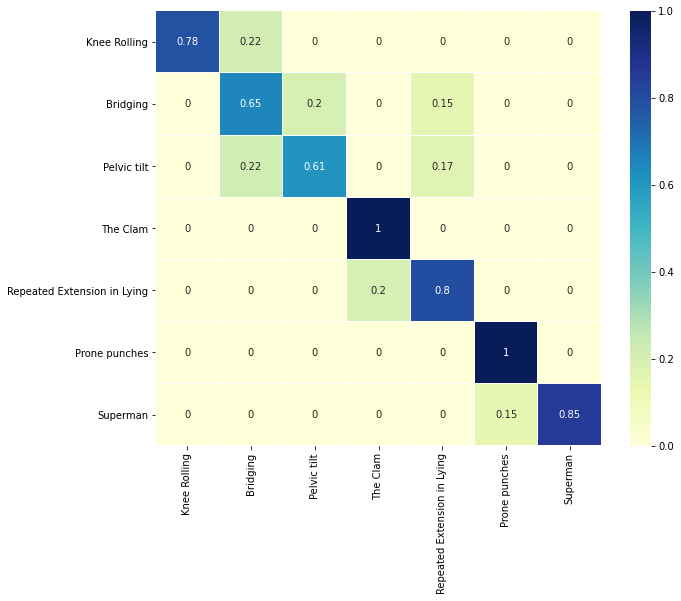

test subjects {6, 7, 8, 9, 10}
train subjects {1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.8508 - accuracy: 0.2631 - val_loss: 1.1083 - val_accuracy: 0.6384
Epoch 2/50
37/37 - 5s - loss: 1.0143 - accuracy: 0.5589 - val_loss: 0.5949 - val_accuracy: 0.8475
Epoch 3/50
37/37 - 5s - loss: 0.6238 - accuracy: 0.7357 - val_loss: 0.6125 - val_accuracy: 0.8305
Epoch 4/50
37/37 - 5s - loss: 0.5362 - accuracy: 0.7816 - val_loss: 0.6105 - val_accuracy: 0.8418
Epoch 5/50
37/37 - 5s - loss: 0.3920 - accuracy: 0.8173 - val_loss: 0.2727 - val_accuracy: 0.9435
Epoch 6/50
37/37 - 5s - loss: 0.3786 - accuracy: 0.8321 - val_loss: 0.7383 - val_accuracy: 0.7740
Epoch 7/50
37/37 - 5s - loss: 0.3938 - accuracy: 0.8343 - val_loss: 0.3531 - val_accuracy: 0.8616
Epoch 8/50
37/37 - 5s - loss: 0.3393 - accuracy: 0.8776 - val_loss: 0.4880 - val_accuracy: 0.8503
Epoch 9/50
37/37 - 5s - loss: 0.2749 - accuracy: 0.8925 - val_loss: 0.1430

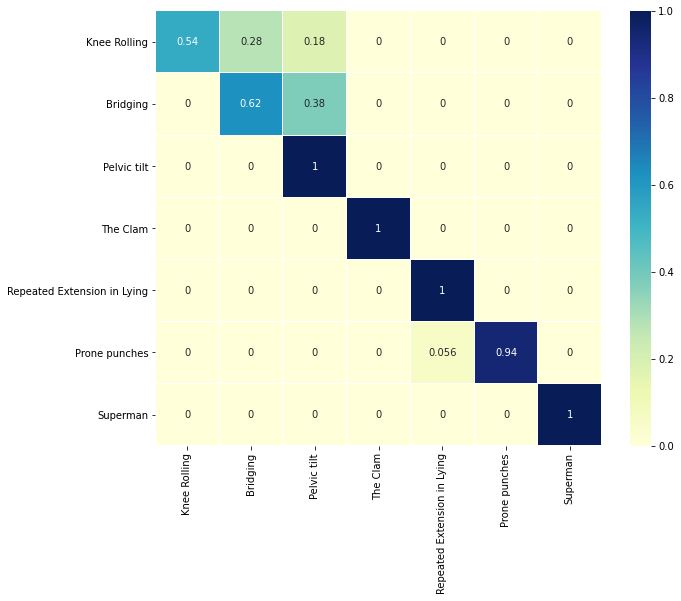

test subjects {11, 12, 13, 14, 15}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.8696 - accuracy: 0.2264 - val_loss: 1.3181 - val_accuracy: 0.3842
Epoch 2/50
37/37 - 5s - loss: 0.8976 - accuracy: 0.6143 - val_loss: 0.3877 - val_accuracy: 0.8898
Epoch 3/50
37/37 - 5s - loss: 0.5906 - accuracy: 0.7281 - val_loss: 0.4889 - val_accuracy: 0.7006
Epoch 4/50
37/37 - 5s - loss: 0.5009 - accuracy: 0.7642 - val_loss: 0.5058 - val_accuracy: 0.7429
Epoch 5/50
37/37 - 5s - loss: 0.5476 - accuracy: 0.7380 - val_loss: 0.4787 - val_accuracy: 0.6893
Epoch 6/50
37/37 - 5s - loss: 0.6232 - accuracy: 0.7363 - val_loss: 0.7968 - val_accuracy: 0.6949
Epoch 7/50
37/37 - 5s - loss: 0.5011 - accuracy: 0.7702 - val_loss: 0.3128 - val_accuracy: 0.9407
Epoch 8/50
37/37 - 5s - loss: 0.4533 - accuracy: 0.7882 - val_loss: 0.4683 - val_accuracy: 0.7910
Epoch 9/50
37/37 - 5s - loss: 0.3574 - accuracy: 0.8346 - val_loss: 0.4148

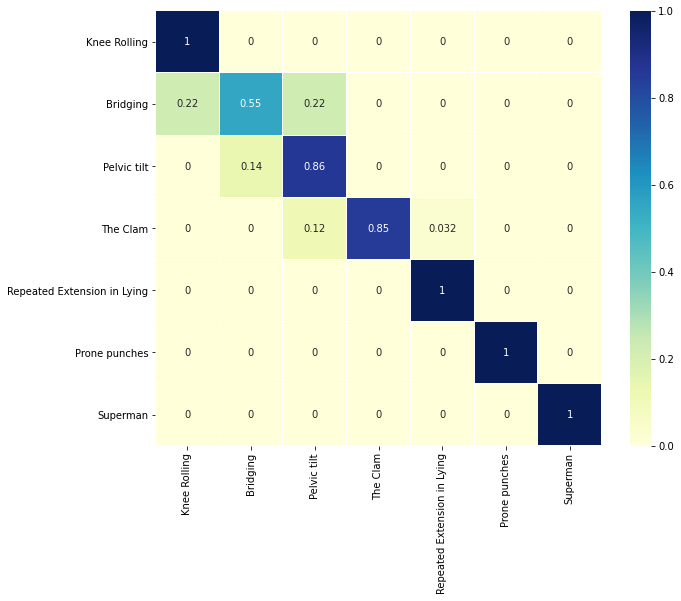

test subjects {16, 17, 18, 19, 20}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.7414 - accuracy: 0.2894 - val_loss: 1.2066 - val_accuracy: 0.4266
Epoch 2/50
37/37 - 5s - loss: 1.0502 - accuracy: 0.5111 - val_loss: 0.7718 - val_accuracy: 0.6328
Epoch 3/50
37/37 - 5s - loss: 0.8085 - accuracy: 0.6055 - val_loss: 0.3812 - val_accuracy: 0.9407
Epoch 4/50
37/37 - 5s - loss: 0.6628 - accuracy: 0.6949 - val_loss: 0.9403 - val_accuracy: 0.7684
Epoch 5/50
37/37 - 5s - loss: 0.5321 - accuracy: 0.7638 - val_loss: 1.1245 - val_accuracy: 0.7062
Epoch 6/50
37/37 - 5s - loss: 0.4700 - accuracy: 0.7860 - val_loss: 0.4879 - val_accuracy: 0.8672
Epoch 7/50
37/37 - 5s - loss: 0.5278 - accuracy: 0.7587 - val_loss: 0.7171 - val_accuracy: 0.7090
Epoch 8/50
37/37 - 5s - loss: 0.4362 - accuracy: 0.7851 - val_loss: 0.6885 - val_accuracy: 0.7232
Epoch 9/50
37/37 - 5s - loss: 0.4211 - accuracy: 0.7940 - val_loss: 0.8880

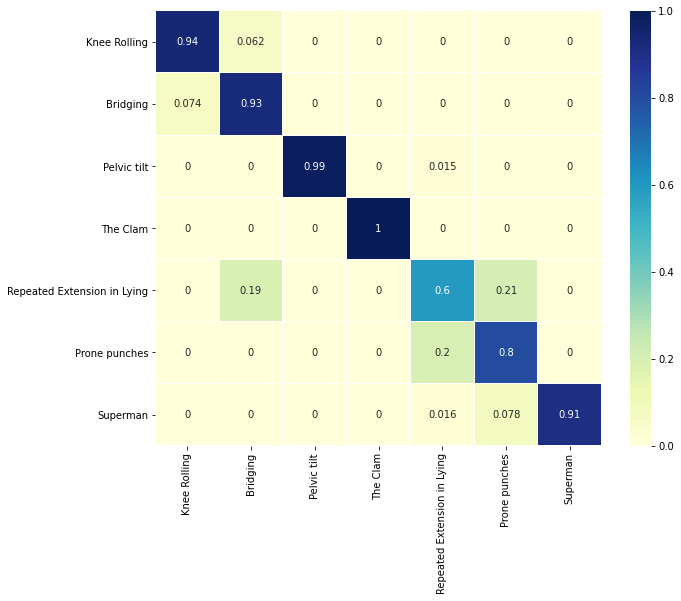

test subjects {21, 22, 23, 24, 25}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 7s - loss: 1.7605 - accuracy: 0.2910 - val_loss: 1.1424 - val_accuracy: 0.4266
Epoch 2/50
37/37 - 5s - loss: 0.8413 - accuracy: 0.6383 - val_loss: 0.6447 - val_accuracy: 0.7458
Epoch 3/50
37/37 - 5s - loss: 0.5142 - accuracy: 0.7618 - val_loss: 0.3930 - val_accuracy: 0.9237
Epoch 4/50
37/37 - 5s - loss: 0.4450 - accuracy: 0.7831 - val_loss: 0.4865 - val_accuracy: 0.7938
Epoch 5/50
37/37 - 5s - loss: 0.3803 - accuracy: 0.8155 - val_loss: 0.2532 - val_accuracy: 0.9379
Epoch 6/50
37/37 - 5s - loss: 0.3326 - accuracy: 0.8513 - val_loss: 0.3604 - val_accuracy: 0.8757
Epoch 7/50
37/37 - 5s - loss: 0.3034 - accuracy: 0.8726 - val_loss: 0.8179 - val_accuracy: 0.8164
Epoch 8/50
37/37 - 5s - loss: 0.5071 - accuracy: 0.8066 - val_loss: 0.9782 - val_accuracy: 0.6808
Epoch 9/50
37/37 - 5s - loss: 0.3501 - accuracy: 0.8441 - val_loss: 0.3344

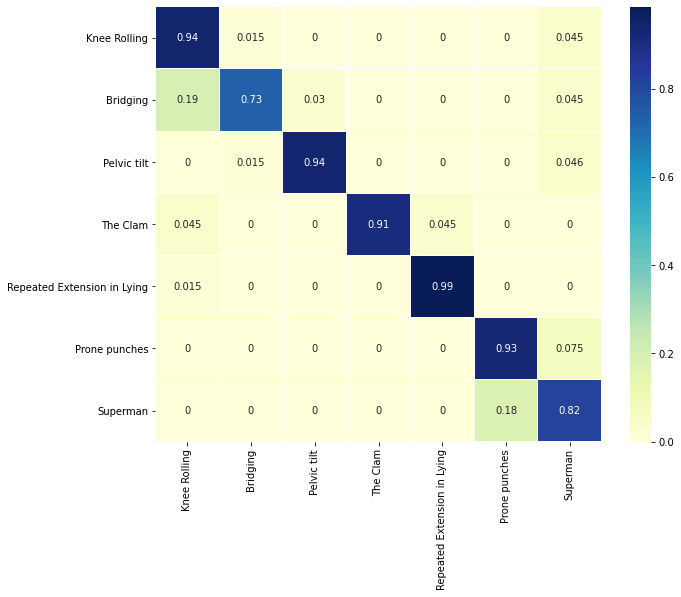

test subjects {26, 27, 28, 29, 30}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Epoch 1/50
37/37 - 6s - loss: 1.7930 - accuracy: 0.2452 - val_loss: 1.3258 - val_accuracy: 0.4266
Epoch 2/50
37/37 - 5s - loss: 1.0602 - accuracy: 0.5066 - val_loss: 0.9402 - val_accuracy: 0.7175
Epoch 3/50
37/37 - 5s - loss: 0.7155 - accuracy: 0.6848 - val_loss: 1.1466 - val_accuracy: 0.5847
Epoch 4/50
37/37 - 5s - loss: 0.4816 - accuracy: 0.8001 - val_loss: 0.8441 - val_accuracy: 0.6977
Epoch 5/50
37/37 - 5s - loss: 0.4883 - accuracy: 0.7988 - val_loss: 0.7462 - val_accuracy: 0.6836
Epoch 6/50
37/37 - 5s - loss: 0.4081 - accuracy: 0.8219 - val_loss: 0.6892 - val_accuracy: 0.8164
Epoch 7/50
37/37 - 5s - loss: 0.4026 - accuracy: 0.8578 - val_loss: 1.0955 - val_accuracy: 0.6045
Epoch 8/50
37/37 - 5s - loss: 0.4451 - accuracy: 0.8317 - val_loss: 0.6728 - val_accuracy: 0.7571
Epoch 9/50
37/37 - 5s - loss: 0.4097 - accuracy: 0.8402 - val_loss: 0.4730

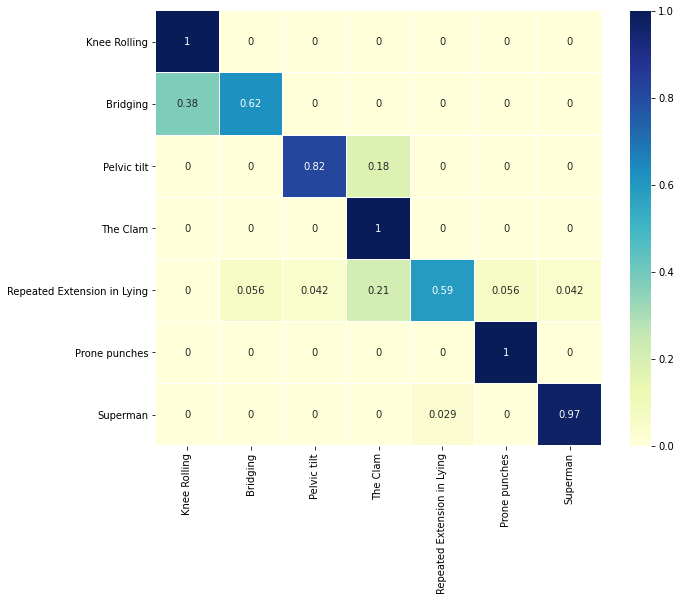

In [97]:
run_experiment(df=main_df)

test subjects {1, 2, 3, 4, 5}
train subjects {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.7999 - accuracy: 0.2947 - val_loss: 1.4045 - val_accuracy: 0.5593
Epoch 2/50
37/37 - 5s - loss: 0.8826 - accuracy: 0.6420 - val_loss: 1.3630 - val_accuracy: 0.6328
Epoch 3/50
37/37 - 5s - loss: 0.5138 - accuracy: 0.7894 - val_loss: 1.2704 - val_accuracy: 0.6638
Epoch 4/50
37/37 - 5s - loss: 0.4046 - accuracy: 0.8214 - val_loss: 1.3298 - val_accuracy: 0.6864
Epoch 5/50
37/37 - 5s - loss: 0.3730 - accuracy: 0.8535 - val_loss: 1.5272 - val_accuracy: 0.7034
Epoch 6/50
37/37 - 5s - loss: 0.3805 - accuracy: 0.8381 - val_loss: 1.5207 - val_accuracy: 0.7119
Epoch 7/50
37/37 - 5s - loss: 0.2831 - accuracy: 0.8842 - val_loss: 1.3420 - val_accuracy: 0.8023
Epoch 8/50
37/37 - 5s - loss: 0.2582 - accuracy: 0.9077 - val_loss: 1.7504 - val_accuracy: 0.6469
Epoch 9/50
37/37 - 5s - loss: 0.3352 - accuracy: 0.8731 - val_loss: 1.7125

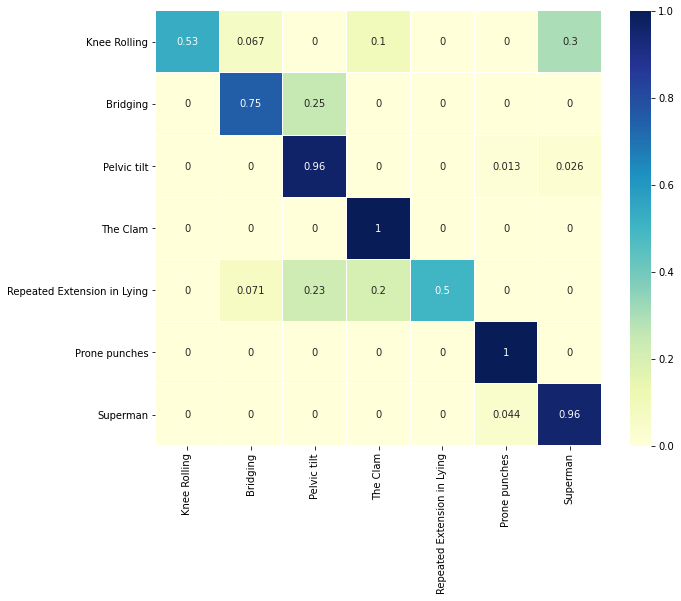

test subjects {6, 7, 8, 9, 10}
train subjects {1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 2.0457 - accuracy: 0.1989 - val_loss: 1.6170 - val_accuracy: 0.3503
Epoch 2/50
37/37 - 5s - loss: 1.3953 - accuracy: 0.4513 - val_loss: 1.1799 - val_accuracy: 0.4492
Epoch 3/50
37/37 - 5s - loss: 0.7927 - accuracy: 0.6791 - val_loss: 0.7811 - val_accuracy: 0.6525
Epoch 4/50
37/37 - 5s - loss: 0.4813 - accuracy: 0.8139 - val_loss: 0.5931 - val_accuracy: 0.7006
Epoch 5/50
37/37 - 5s - loss: 0.4031 - accuracy: 0.8419 - val_loss: 0.9133 - val_accuracy: 0.7684
Epoch 6/50
37/37 - 5s - loss: 0.3313 - accuracy: 0.8870 - val_loss: 0.6028 - val_accuracy: 0.8362
Epoch 7/50
37/37 - 5s - loss: 0.2769 - accuracy: 0.9065 - val_loss: 0.5380 - val_accuracy: 0.8333
Epoch 8/50
37/37 - 5s - loss: 0.3185 - accuracy: 0.8908 - val_loss: 0.7515 - val_accuracy: 0.7881
Epoch 9/50
37/37 - 5s - loss: 0.2772 - accuracy: 0.9193 - val_loss: 0.5129

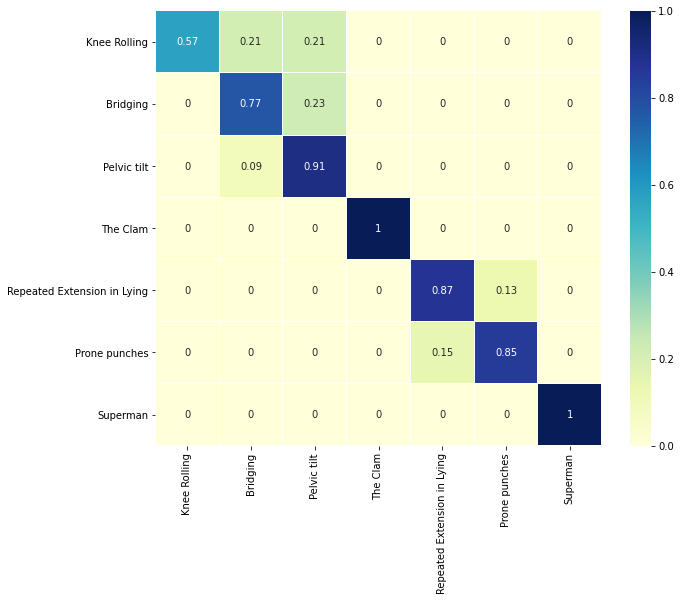

test subjects {11, 12, 13, 14, 15}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.9019 - accuracy: 0.2388 - val_loss: 1.5519 - val_accuracy: 0.4350
Epoch 2/50
37/37 - 5s - loss: 1.3043 - accuracy: 0.4218 - val_loss: 1.2327 - val_accuracy: 0.3955
Epoch 3/50
37/37 - 5s - loss: 0.7675 - accuracy: 0.6465 - val_loss: 0.7870 - val_accuracy: 0.6610
Epoch 4/50
37/37 - 5s - loss: 0.6075 - accuracy: 0.7483 - val_loss: 0.8090 - val_accuracy: 0.7881
Epoch 5/50
37/37 - 5s - loss: 0.4761 - accuracy: 0.7728 - val_loss: 0.7054 - val_accuracy: 0.6384
Epoch 6/50
37/37 - 5s - loss: 0.4002 - accuracy: 0.8106 - val_loss: 0.2916 - val_accuracy: 0.8418
Epoch 7/50
37/37 - 5s - loss: 0.3602 - accuracy: 0.8282 - val_loss: 0.5732 - val_accuracy: 0.8983
Epoch 8/50
37/37 - 5s - loss: 0.4246 - accuracy: 0.8204 - val_loss: 0.7237 - val_accuracy: 0.8362
Epoch 9/50
37/37 - 5s - loss: 0.3635 - accuracy: 0.8320 - val_loss: 0.4611

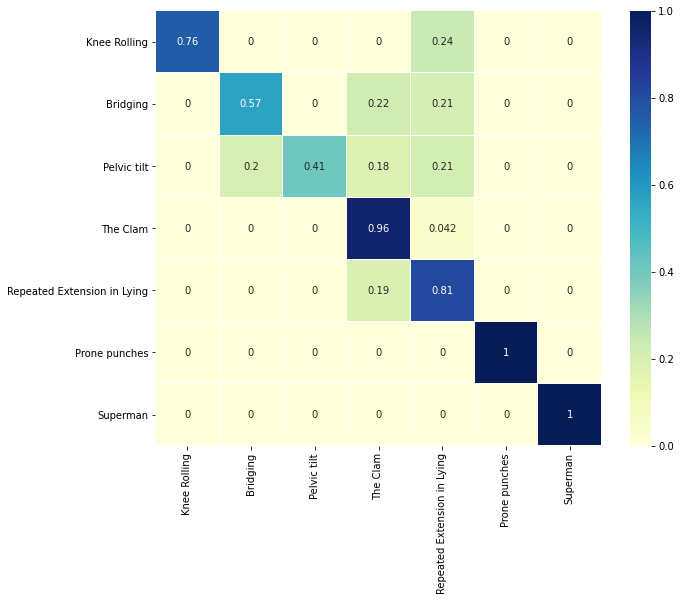

test subjects {16, 17, 18, 19, 20}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 2.0733 - accuracy: 0.1804 - val_loss: 1.5310 - val_accuracy: 0.2910
Epoch 2/50
37/37 - 5s - loss: 1.3066 - accuracy: 0.4834 - val_loss: 0.9259 - val_accuracy: 0.6299
Epoch 3/50
37/37 - 5s - loss: 0.7068 - accuracy: 0.7430 - val_loss: 0.4773 - val_accuracy: 0.8051
Epoch 4/50
37/37 - 5s - loss: 0.4616 - accuracy: 0.8332 - val_loss: 0.5556 - val_accuracy: 0.8079
Epoch 5/50
37/37 - 5s - loss: 0.3811 - accuracy: 0.8651 - val_loss: 0.9312 - val_accuracy: 0.7260
Epoch 6/50
37/37 - 5s - loss: 0.3192 - accuracy: 0.8970 - val_loss: 0.5239 - val_accuracy: 0.8672
Epoch 7/50
37/37 - 5s - loss: 0.3765 - accuracy: 0.8826 - val_loss: 0.4671 - val_accuracy: 0.8701
Epoch 8/50
37/37 - 5s - loss: 0.3443 - accuracy: 0.8915 - val_loss: 0.5061 - val_accuracy: 0.8785
Epoch 9/50
37/37 - 5s - loss: 0.2912 - accuracy: 0.9055 - val_loss: 0.2642

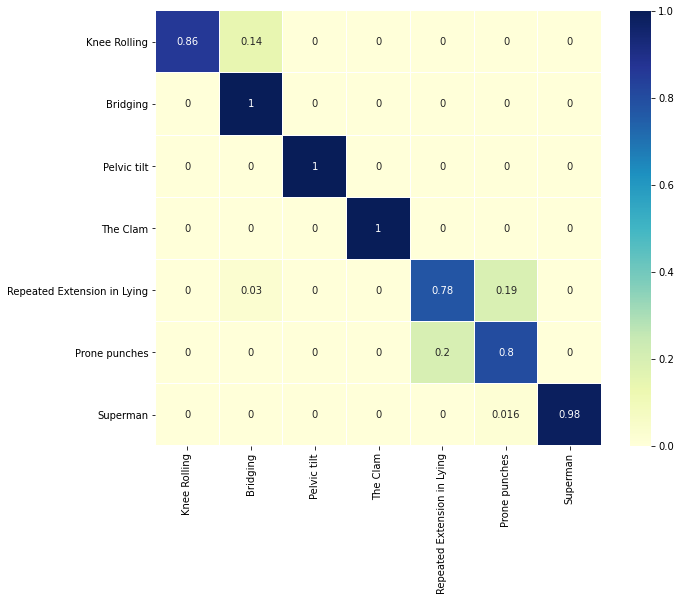

test subjects {21, 22, 23, 24, 25}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 2.0259 - accuracy: 0.2096 - val_loss: 1.5251 - val_accuracy: 0.4859
Epoch 2/50
37/37 - 5s - loss: 1.1864 - accuracy: 0.5266 - val_loss: 0.8557 - val_accuracy: 0.7373
Epoch 3/50
37/37 - 5s - loss: 0.7805 - accuracy: 0.6821 - val_loss: 0.4864 - val_accuracy: 0.8559
Epoch 4/50
37/37 - 5s - loss: 0.6384 - accuracy: 0.7235 - val_loss: 0.3642 - val_accuracy: 0.9322
Epoch 5/50
37/37 - 5s - loss: 0.5070 - accuracy: 0.7870 - val_loss: 0.7120 - val_accuracy: 0.8531
Epoch 6/50
37/37 - 5s - loss: 0.4217 - accuracy: 0.8002 - val_loss: 0.6457 - val_accuracy: 0.8814
Epoch 7/50
37/37 - 5s - loss: 0.3650 - accuracy: 0.8402 - val_loss: 0.8105 - val_accuracy: 0.8418
Epoch 8/50
37/37 - 5s - loss: 0.4211 - accuracy: 0.8061 - val_loss: 0.3747 - val_accuracy: 0.9379
Epoch 9/50
37/37 - 5s - loss: 0.3308 - accuracy: 0.8466 - val_loss: 0.5414

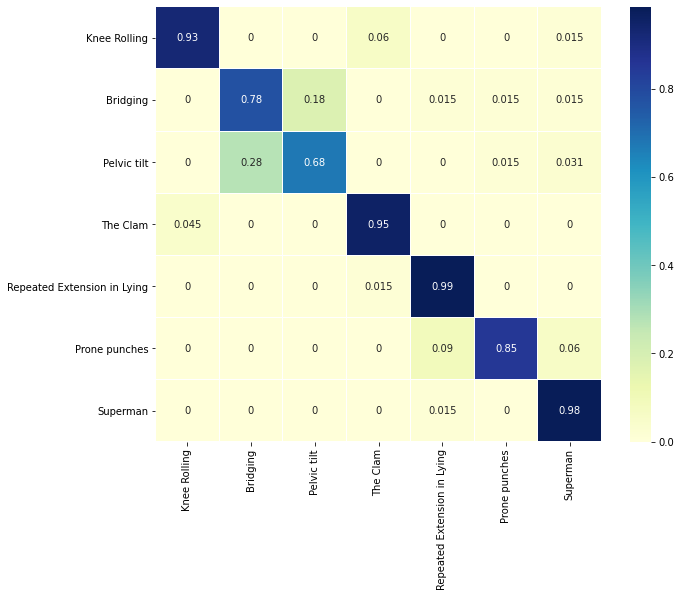

test subjects {26, 27, 28, 29, 30}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Epoch 1/50
37/37 - 6s - loss: 1.8395 - accuracy: 0.2678 - val_loss: 1.1723 - val_accuracy: 0.4831
Epoch 2/50
37/37 - 5s - loss: 0.9454 - accuracy: 0.5882 - val_loss: 0.8333 - val_accuracy: 0.6328
Epoch 3/50
37/37 - 5s - loss: 0.5826 - accuracy: 0.7557 - val_loss: 0.7229 - val_accuracy: 0.6780
Epoch 4/50
37/37 - 5s - loss: 0.4937 - accuracy: 0.7710 - val_loss: 0.6101 - val_accuracy: 0.8785
Epoch 5/50
37/37 - 5s - loss: 0.4400 - accuracy: 0.8069 - val_loss: 0.5208 - val_accuracy: 0.8701
Epoch 6/50
37/37 - 5s - loss: 0.4610 - accuracy: 0.8039 - val_loss: 0.4864 - val_accuracy: 0.8333
Epoch 7/50
37/37 - 5s - loss: 0.3822 - accuracy: 0.8334 - val_loss: 0.6826 - val_accuracy: 0.8051
Epoch 8/50
37/37 - 5s - loss: 0.3679 - accuracy: 0.8317 - val_loss: 0.5105 - val_accuracy: 0.8672
Epoch 9/50
37/37 - 5s - loss: 0.3556 - accuracy: 0.8578 - val_loss: 0.5764

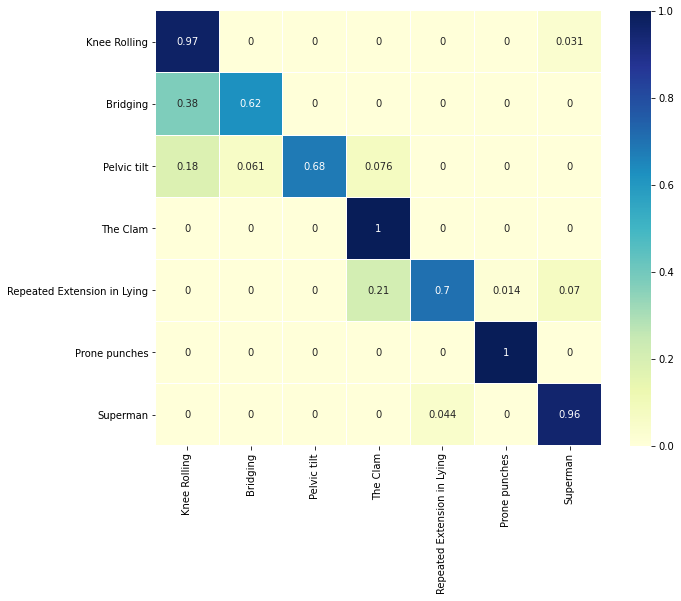

In [103]:
run_experiment(df=main_df, BATCH_SIZE =32)

test subjects {1, 2, 3, 4, 5}
train subjects {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.7045 - accuracy: 0.2905 - val_loss: 1.1174 - val_accuracy: 0.5734
Epoch 2/50
37/37 - 5s - loss: 0.7673 - accuracy: 0.6450 - val_loss: 1.2550 - val_accuracy: 0.5734
Epoch 3/50
37/37 - 5s - loss: 0.4759 - accuracy: 0.8116 - val_loss: 1.6025 - val_accuracy: 0.6073
Epoch 4/50
37/37 - 5s - loss: 0.4263 - accuracy: 0.8368 - val_loss: 1.4574 - val_accuracy: 0.7175
Epoch 5/50
37/37 - 5s - loss: 0.3540 - accuracy: 0.8710 - val_loss: 1.2159 - val_accuracy: 0.7740
Epoch 6/50
37/37 - 5s - loss: 0.3285 - accuracy: 0.8795 - val_loss: 0.8396 - val_accuracy: 0.8164
Epoch 7/50
37/37 - 5s - loss: 0.6533 - accuracy: 0.7386 - val_loss: 1.5993 - val_accuracy: 0.6045
Epoch 8/50
37/37 - 5s - loss: 0.3965 - accuracy: 0.8526 - val_loss: 1.4218 - val_accuracy: 0.6808
Epoch 9/50
37/37 - 5s - loss: 0.2924 - accuracy: 0.8988 - val_loss: 1.4388

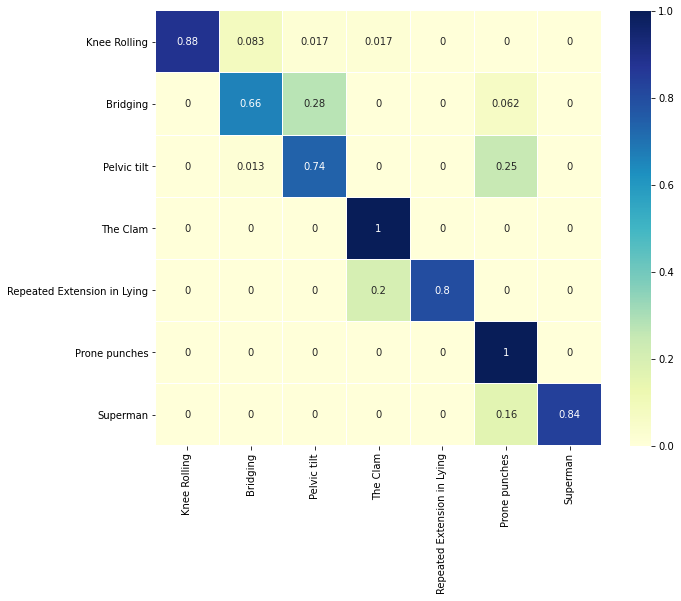

test subjects {6, 7, 8, 9, 10}
train subjects {1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.6550 - accuracy: 0.3591 - val_loss: 0.9070 - val_accuracy: 0.6469
Epoch 2/50
37/37 - 5s - loss: 0.7421 - accuracy: 0.7051 - val_loss: 0.4477 - val_accuracy: 0.8023
Epoch 3/50
37/37 - 5s - loss: 0.4879 - accuracy: 0.7807 - val_loss: 0.6879 - val_accuracy: 0.7429
Epoch 4/50
37/37 - 5s - loss: 0.4292 - accuracy: 0.8215 - val_loss: 0.3500 - val_accuracy: 0.8983
Epoch 5/50
37/37 - 5s - loss: 0.3346 - accuracy: 0.8644 - val_loss: 0.2481 - val_accuracy: 0.8983
Epoch 6/50
37/37 - 5s - loss: 0.2252 - accuracy: 0.9133 - val_loss: 0.3824 - val_accuracy: 0.8588
Epoch 7/50
37/37 - 5s - loss: 0.2104 - accuracy: 0.9248 - val_loss: 0.5753 - val_accuracy: 0.8475
Epoch 8/50
37/37 - 5s - loss: 0.3230 - accuracy: 0.8844 - val_loss: 0.4421 - val_accuracy: 0.8701
Epoch 9/50
37/37 - 5s - loss: 0.2909 - accuracy: 0.8972 - val_loss: 0.4306

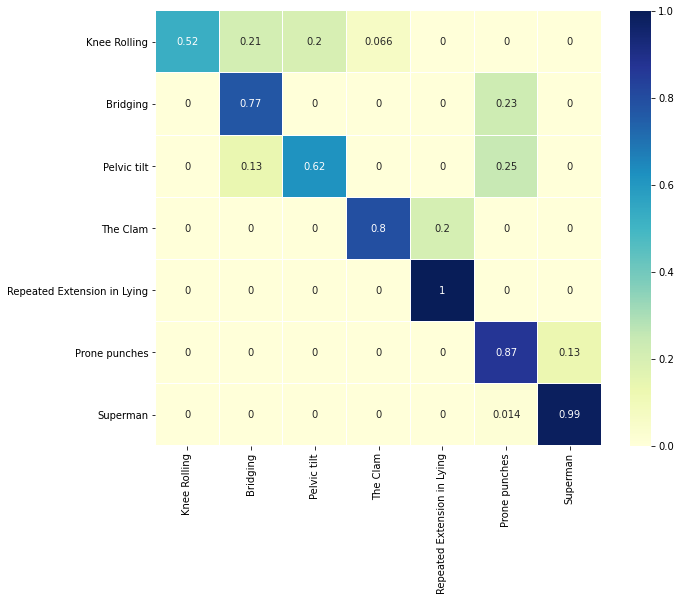

test subjects {11, 12, 13, 14, 15}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.8678 - accuracy: 0.2573 - val_loss: 1.2784 - val_accuracy: 0.5028
Epoch 2/50
37/37 - 5s - loss: 0.9948 - accuracy: 0.5399 - val_loss: 0.6511 - val_accuracy: 0.7712
Epoch 3/50
37/37 - 5s - loss: 0.6524 - accuracy: 0.7161 - val_loss: 0.4728 - val_accuracy: 0.8814
Epoch 4/50
37/37 - 5s - loss: 0.4602 - accuracy: 0.7938 - val_loss: 0.4748 - val_accuracy: 0.8192
Epoch 5/50
37/37 - 5s - loss: 0.3273 - accuracy: 0.8630 - val_loss: 0.2722 - val_accuracy: 0.9068
Epoch 6/50
37/37 - 5s - loss: 0.4199 - accuracy: 0.8424 - val_loss: 0.6734 - val_accuracy: 0.7768
Epoch 7/50
37/37 - 5s - loss: 0.3364 - accuracy: 0.8754 - val_loss: 0.4497 - val_accuracy: 0.8701
Epoch 8/50
37/37 - 5s - loss: 0.2017 - accuracy: 0.9278 - val_loss: 0.3642 - val_accuracy: 0.8701
Epoch 9/50
37/37 - 5s - loss: 0.2216 - accuracy: 0.9265 - val_loss: 0.3660

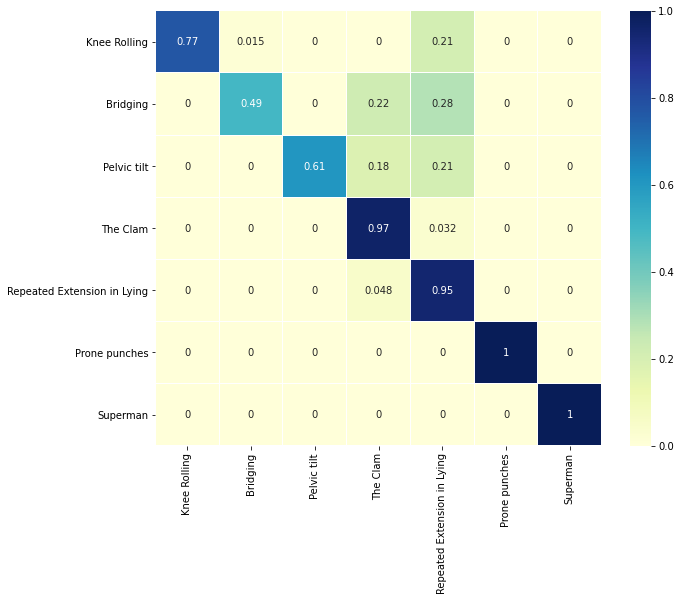

test subjects {16, 17, 18, 19, 20}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 7s - loss: 1.6617 - accuracy: 0.3187 - val_loss: 0.7346 - val_accuracy: 0.6667
Epoch 2/50
37/37 - 5s - loss: 0.7337 - accuracy: 0.6894 - val_loss: 0.6596 - val_accuracy: 0.8475
Epoch 3/50
37/37 - 5s - loss: 0.4574 - accuracy: 0.7911 - val_loss: 0.5710 - val_accuracy: 0.7712
Epoch 4/50
37/37 - 5s - loss: 0.3991 - accuracy: 0.8213 - val_loss: 1.0174 - val_accuracy: 0.7373
Epoch 5/50
37/37 - 5s - loss: 0.3533 - accuracy: 0.8370 - val_loss: 0.3868 - val_accuracy: 0.9040
Epoch 6/50
37/37 - 5s - loss: 0.3580 - accuracy: 0.8489 - val_loss: 0.6949 - val_accuracy: 0.7853
Epoch 7/50
37/37 - 5s - loss: 0.2387 - accuracy: 0.9043 - val_loss: 0.7129 - val_accuracy: 0.7910
Epoch 8/50
37/37 - 5s - loss: 0.2197 - accuracy: 0.9119 - val_loss: 0.8645 - val_accuracy: 0.8475
Epoch 9/50
37/37 - 5s - loss: 0.3166 - accuracy: 0.8762 - val_loss: 0.4063

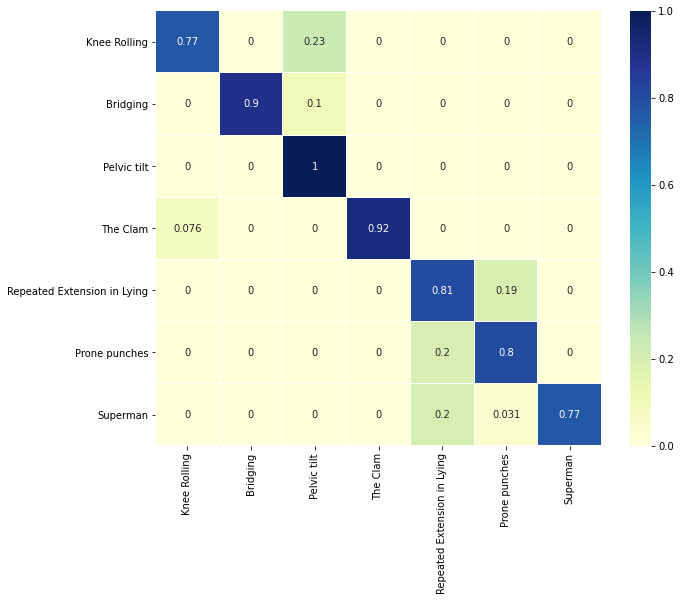

test subjects {21, 22, 23, 24, 25}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30}
Epoch 1/50
37/37 - 6s - loss: 1.7814 - accuracy: 0.2859 - val_loss: 1.3509 - val_accuracy: 0.3220
Epoch 2/50
37/37 - 5s - loss: 0.9407 - accuracy: 0.5548 - val_loss: 0.6731 - val_accuracy: 0.6808
Epoch 3/50
37/37 - 5s - loss: 0.7183 - accuracy: 0.6979 - val_loss: 0.7675 - val_accuracy: 0.6356
Epoch 4/50
37/37 - 5s - loss: 0.4873 - accuracy: 0.7763 - val_loss: 0.6725 - val_accuracy: 0.7401
Epoch 5/50
37/37 - 5s - loss: 0.3674 - accuracy: 0.8155 - val_loss: 0.3438 - val_accuracy: 0.9633
Epoch 6/50
37/37 - 5s - loss: 0.3983 - accuracy: 0.8014 - val_loss: 0.5974 - val_accuracy: 0.7345
Epoch 7/50
37/37 - 5s - loss: 0.3855 - accuracy: 0.8083 - val_loss: 0.5033 - val_accuracy: 0.9181
Epoch 8/50
37/37 - 5s - loss: 0.4662 - accuracy: 0.8002 - val_loss: 0.7076 - val_accuracy: 0.8079
Epoch 9/50
37/37 - 5s - loss: 0.3613 - accuracy: 0.8347 - val_loss: 0.5590

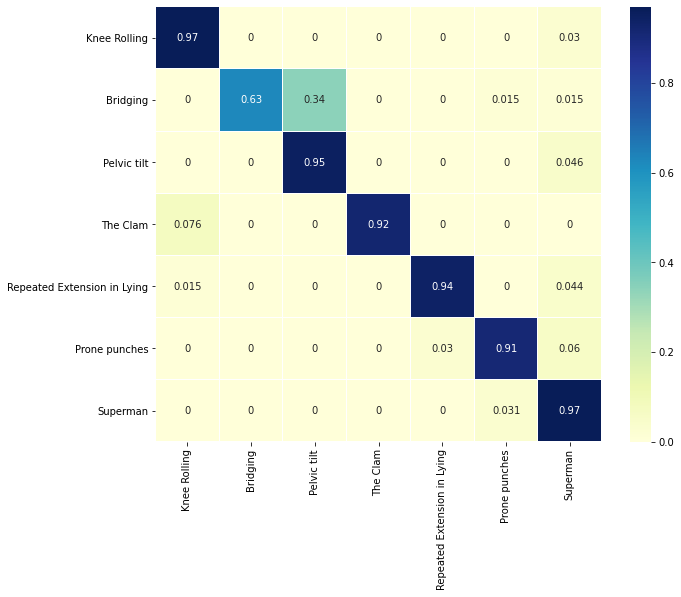

test subjects {26, 27, 28, 29, 30}
train subjects {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Epoch 1/50
37/37 - 6s - loss: 1.8532 - accuracy: 0.2542 - val_loss: 1.3330 - val_accuracy: 0.5000
Epoch 2/50
37/37 - 5s - loss: 1.1374 - accuracy: 0.5203 - val_loss: 0.7988 - val_accuracy: 0.7740
Epoch 3/50
37/37 - 5s - loss: 0.7575 - accuracy: 0.6984 - val_loss: 0.7973 - val_accuracy: 0.7034
Epoch 4/50
37/37 - 5s - loss: 0.5936 - accuracy: 0.7535 - val_loss: 0.4027 - val_accuracy: 0.8475
Epoch 5/50
37/37 - 5s - loss: 0.4743 - accuracy: 0.8052 - val_loss: 0.4761 - val_accuracy: 0.8672
Epoch 6/50
37/37 - 5s - loss: 0.5164 - accuracy: 0.7821 - val_loss: 0.6329 - val_accuracy: 0.8220
Epoch 7/50
37/37 - 5s - loss: 0.4937 - accuracy: 0.7886 - val_loss: 0.6126 - val_accuracy: 0.6893
Epoch 8/50
37/37 - 5s - loss: 0.3900 - accuracy: 0.8202 - val_loss: 0.8679 - val_accuracy: 0.6412
Epoch 9/50
37/37 - 5s - loss: 0.3586 - accuracy: 0.8407 - val_loss: 0.5651

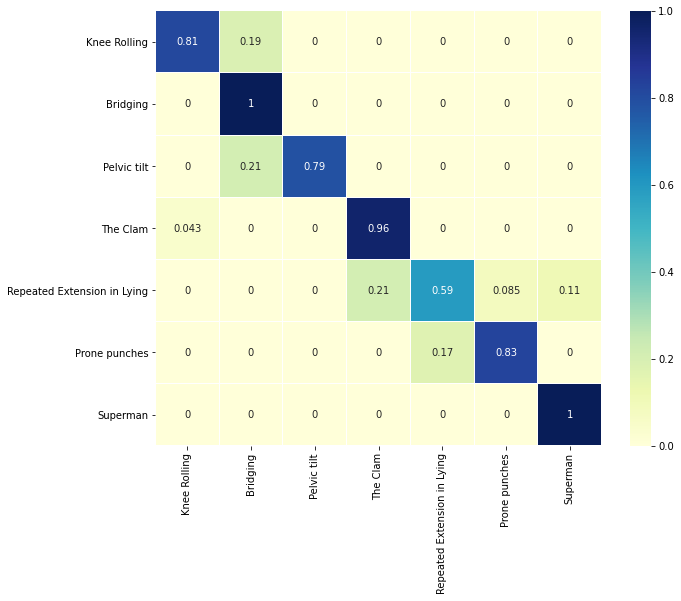

In [104]:
run_experiment(df=main_df, BATCH_SIZE = 64)

## LOSO